### 一.半朴素贝叶斯分类器
上一节介绍了朴素贝叶斯，它假设属性之间相互独立，但现实任务中这种假设往往很难成立，“半朴素贝叶斯”就是在朴素贝叶斯的基础上尝试为部分属性添加依赖关系，其常用的一种策略被称为独依赖估计（One-Dependent Estimator,ODE），即假设每个属性在类别之外最多仅依赖于一个其他属性，通常的做法有两种，下面简单介绍一下 

#### SPODE
SPODE(Super-Parent ODE)的做法是假设所有属性都依赖于同一个属性，该属性称为“超父”，比如下图是“超父”为$X_1$的SPODE
![avatar](./source/12_半朴素贝叶斯SPODE.png)
#### TAN
TAN(Tree Augmented Naive Bayes)则是根据条件互信息构建一个最大带权生成树，然后再添加$Y$到每个属性的指向来构建半朴素贝叶斯分类器，假设目前仅有$X_1,X_2,X_3,X_4$这4个属性，下面说明其构建过程：   

>(1)计算任意两个属性直接的条件互信息：  

$$
I(X_i,X_j)=\sum_{X_i,X_j,c}p(X_i,X_j\mid Y=c)log\frac{p(X_i,X_j\mid Y=c)}{p(X_i\mid Y=c)\cdot p(X_j\mid Y=c)},i\neq j,i,j\in \{1,2,3,4\}
$$  
>(2)以属性为节点构建完全图，任意两个节点之间边的权重设为其条件互信息值：  

![avatar](./source/12_半朴素贝叶斯TAN1.png)  

>(3)构建此完全图的最大带权生成树，挑选根变量，将边置为有向：  

![avatar](./source/12_半朴素贝叶斯TAN2.png)

>(4)增加类别节点$Y$，增加从$Y$到每个属性的有向边  

![avatar](./source/12_半朴素贝叶斯TAN3.png)

### 二.参数估计
半朴素贝叶斯分类器可以定义如下：   

$$
f(x)=arg\max_{c_k}P(Y=c_k)\prod_{i=1}^nP(X_i=x_i\mid Y=c_k,X_{Pa(i)})
$$  

这里$X_{Pa(i)}$为属性$X_i$所依赖的属性，比如对上面的概率图有$Pa(2)=X_1$，接下来同之前的问题一样，就是参数估计的问题，这里我们同样可以采用极大似然估计的方法：    

#### 1.求解$p(Y=c_k)$

$$
p(Y=c_k)=\frac{\sum_{i=1}^NI(y_i=c_k)}{N},k=1,2,...,K,N表示样本量
$$  

#### 2.求解$p(X_i=x_i\mid Y=c_k,X_{Pa(i)}=Pa(i)_j)$
假设第$i$个特征可能的取值为$A_i=\{a_{i1},a_{i2},...,a_{iS_i}\}$，第$Pa(i)$特征的可能的取值为$B_i=\{b_{i1},b_{i2},...,b_{iS_i}\}$,所以有$x_i=a_{il}\in A_i,Pa(i)=b_{im}\in B_i$，所以：   

$$
p(X_i=a_{il}\mid Y=c_k,Pa(i)=b_{im})=\frac{\sum_{j=1}^NI(x_i^j=a_{il},y_i=c_k,Pa(i)^j=b_{im})}{\sum_{j=1}^nI(y_j=c_k,Pa(i)^j=b_{im})}
$$  

类比上一节，对于连续值的情况，我们可以采用二维高斯分布（参数求解见EM那一章）去拟合即可

### 三.代码实现
这里就偷个懒，懒得去划分区间再统计了，就用高斯分布去拟合...

In [1]:
import os
os.chdir('../')
import numpy as np
from ml_models import utils
%matplotlib inline

"""
半朴素贝叶斯分类器实现，封装到ml_models.pgm
"""

class SemiGaussianNBClassifier(object):
    def __init__(self, link_rulers=None):
        """
        :param link_rulers: 属性间的链接关系[(x1,x2),(x3,x4)]
        """
        self.p_y = {}  # p(y)
        self.p_x_y = {}  # p(x | y)
        self.class_num = None
        self.link_rulers = link_rulers
        # check link_rulers，由于某一个属性最多仅依赖于另一个属性，所以某一属性在尾部出现次数不可能大于1次
        self.tail_link_rulers = {}
        if self.link_rulers is not None and len(self.link_rulers) > 0:
            for x1, x2 in self.link_rulers:
                if x2 in self.tail_link_rulers:
                    raise Exception("属性依赖超过1次")
                self.tail_link_rulers[x2] = [x1, x2]

    def fit(self, x, y):
        # 参数估计
        self.class_num = y.max() + 1
        for y_index in range(0, self.class_num):
            # p(y)
            y_n_sample = np.sum(y == y_index)
            self.p_y[y_index] = np.log(y_n_sample / len(y))
            self.p_x_y[y_index] = {}
            # p(x | y)
            x_y = x[y == y_index]
            for i in range(0, x_y.shape[1]):
                # 如果i在link_rulers的尾部，则需要构建二维高斯分布
                if i in self.tail_link_rulers:
                    first_feature, second_feature = self.tail_link_rulers[i]
                    u = np.mean(x_y[:, [first_feature, second_feature]], axis=0)
                    sigma = np.cov(x_y[:, [first_feature, second_feature]].T)
                else:
                    u = np.mean(x_y[:, i])
                    sigma = np.std(x_y[:, i])
                self.p_x_y[y_index][i] = [u, sigma]

    def predict_proba(self, x):
        rst = []
        for x_row in x:
            tmp = []
            for y_index in range(0, self.class_num):
                p_y_log = self.p_y[y_index]
                for j in range(0, len(x_row)):
                    if j in self.tail_link_rulers:
                        first_feature, second_feature = self.tail_link_rulers[j]
                        xij = x_row[[first_feature, second_feature]]
                        p_y_log += np.log(utils.gaussian_nd(xij, self.p_x_y[y_index][j][0], self.p_x_y[y_index][j][1]))
                    else:
                        xij = x_row[j]
                        p_y_log += np.log(utils.gaussian_1d(xij, self.p_x_y[y_index][j][0], self.p_x_y[y_index][j][1]))
                tmp.append(p_y_log)
            rst.append(tmp)
        return utils.softmax(np.asarray(rst)).reshape(x.shape[0], self.class_num)

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1).reshape(-1)

In [2]:
#造伪数据
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=400, centers=4, cluster_std=0.85, random_state=0)
X = X[:, ::-1]

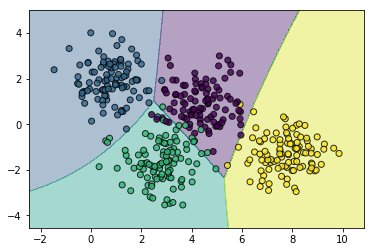

In [3]:
#查看效果
snb = SemiGaussianNBClassifier(link_rulers=[(0,1)])
snb.fit(X, y)
utils.plot_decision_function(X, y, snb)

`link_rulers=[(0,1)]`表示添加了一条$x_1\rightarrow x_2$的依赖，如果不添加，则和上一节的效果一样

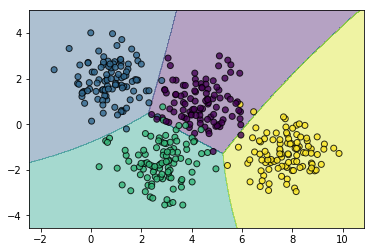

In [4]:
#查看效果
snb = SemiGaussianNBClassifier()
snb.fit(X, y)
utils.plot_decision_function(X, y, snb)

这里并没有对SPODE或TAN做具体实现，仅对其添加了`link_rulers`参数做支持